In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '104-flowers-garden-of-eden:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F514569%2F948457%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T194934Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6dc5f72c9d0f33b615df19df16bf2b8c70d19924e0a184358ae961c4aa89bdc98997f160f6aca601b775e1f9eaba03a9e663b3eedc85f31116717c1f3f213c4d587a760fd97d7b3df8d14bf3d9c136085e0fef532fb5b175179d98e6cbbb3eafa2dfc5a7bfed5a529a9a1b233c4b742122c4de1465853696c47c97921f2ef85342f3279f04884ed17bc682e7b1c069c0269fa452be35c03f57345c132e5e65476f6790dcfe9a66fd02a225d557f70748780c7a3aa7a2cc6ff9f5535d97c7c7c5e89195def0b3efe58ec8864e3e7bf69c454ab8452a80e064e9f7953527de7c3752befd77f0b2c41e2ddc19bc9ed1931db729d668ec55baef38cd33f3b8c7d93c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1880038216 bytes downloaded
Downloaded and uncompressed: 104-flowers-garden-of-eden
Data source import complete.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
# Вказати шлях до датасету
dataset_dir = '/kaggle/input/104-flowers-garden-of-eden/jpeg-224x224/val'

# Вказати шлях до папок для навчальної і тестової вибірок
train_dir = '/kaggle/input/104-flowers-garden-of-eden/jpeg-224x224/train'
val_dir = '/kaggle/input/104-flowers-garden-of-eden/jpeg-224x224/val'
test_dir = '/kaggle/input/104-flowers-garden-of-eden/jpeg-224x224/test'

In [ ]:
# Створити папки для навчальної і тестової вибірок
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Отримати список всіх підпапок (класів)
class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Розділити кожний клас на навчальну і тестову вибірки
for class_dir in class_dirs:
    class_path = os.path.join(dataset_dir, class_dir)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    train_class_dir = os.path.join(train_dir, class_dir)
    test_class_dir = os.path.join(test_dir, class_dir)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("Data split into train and test sets.")

Data split into train and test sets.


In [ ]:
# Параметри для генератора даних
img_height, img_width = 224, 224
batch_size = 32

# Генератор для навчальної вибірки
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Генератор для тестової вибірки
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15679 images belonging to 104 classes.
Found 786 images belonging to 104 classes.


In [ ]:
# Завантаження базової моделі
base_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# Побудова моделі
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Тренування моделі
epochs = 15
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs
)

Epoch 1/15
490/490 [==============================] - 82s 144ms/step - loss: 2.0534 - accuracy: 0.4979 - val_loss: 1.3114 - val_accuracy: 0.6501
Epoch 2/15
490/490 [==============================] - 67s 137ms/step - loss: 1.2200 - accuracy: 0.6651 - val_loss: 1.0419 - val_accuracy: 0.7265
Epoch 3/15
490/490 [==============================] - 68s 140ms/step - loss: 0.9619 - accuracy: 0.7340 - val_loss: 0.9728 - val_accuracy: 0.7379
Epoch 4/15
490/490 [==============================] - 69s 140ms/step - loss: 0.8102 - accuracy: 0.7643 - val_loss: 0.9123 - val_accuracy: 0.7455
Epoch 5/15
490/490 [==============================] - 69s 140ms/step - loss: 0.6937 - accuracy: 0.7981 - val_loss: 0.9063 - val_accuracy: 0.7481
Epoch 6/15
490/490 [==============================] - 70s 144ms/step - loss: 0.6007 - accuracy: 0.8226 - val_loss: 0.9189 - val_accuracy: 0.7379
Epoch 7/15
490/490 [==============================] - 69s 141ms/step - loss: 0.5248 - accuracy: 0.8414 - val_loss: 0.8695 - val_ac

In [ ]:
# Оцінка моделі
loss, accuracy = model.evaluate(test_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

25/25 [==============================] - 3s 127ms/step - loss: 1.0042 - accuracy: 0.7710
Validation Accuracy: 77.10%


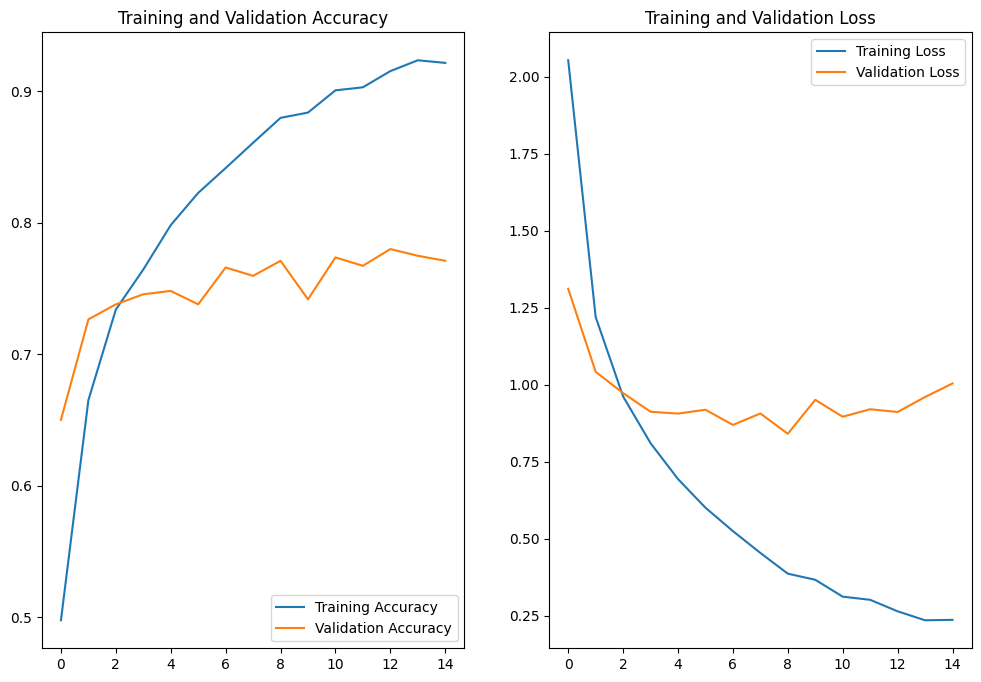

In [ ]:
# Виведення графіків точності та втрат
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Виклик функції для виведення графіків
plot_training_history(history)

In [ ]:
# Збереження моделі
model.save('Xception_model_updated.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
